Meyve Sınıflandırma Projesi

Makine Öğrenmesine Giriş – Final Projesi

Grup Üyeleri:

Sena Nur Pınarbaşı – 2221221054

Serpil Elinç – 2321021743

Projenin Amacı

Bu proje kapsamında, üç farklı meyve sınıfına ait görüntüler kullanılarak bir görüntü sınıflandırma modeli geliştirilmesi hedeflenmektedir. Sınıflandırılacak sınıflar:

->Elma (apple)

->Muz (banana)

->Portakal (orange)

->Çilek(strawberry)

Toplanan görseller kullanılarak iki farklı yöntem karşılaştırılacaktır:

1-) HOG + Random Forest (Klasik makine öğrenmesi yöntemi)

2-) Convolutional Neural Network – CNN (Derin öğrenme yöntemi)

Her iki model performans, doğruluk, hatalar ve çalışma süresi açısından değerlendirilecektir.

 Veri Kümesi

-Görseller Google Görseller ve benzeri kaynaklardan manuel olarak toplanmıştır.

-Her sınıf için yaklaşık 75 adet görüntü bulunmaktadır.

-Görseller 128×128 piksel olacak şekilde yeniden boyutlandırılacaktır.

-Veri kümesi eğitim, doğrulama ve test olarak bölünecektir.

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import io, transform
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import tensorflow as tf
import joblib
from tensorflow.keras import layers, models

#Resimlerin olduğu ana klasörün bilgisayarımızdaki adı
DATA_DIR = "makinedataset"  

#Tanımak istediğimiz meyvelerin listesi (Klasör isimleri)
CLASSES = ["cilek_dataset", "elma_dataset", "muz_dataset", "portakal_dataset"]


#Tüm resimleri aynı boyuta getiriyoruz(128x128 piksel)
IMG_SIZE = (128, 128)

print("Kütüphaneler yüklendi ve ayarlar hazır.")


Kütüphaneler yüklendi ve ayarlar hazır.


In [26]:
def load_dataset(data_dir, classes, img_size):
    # Boş kutular açıyoruz: X resimleri, y ise bunların ne olduğunu (çilek, elma vb.) tutacak
    X = []
    y = []

    # Meyve klasörlerimizi sırayla gezmeye başlıyoruz
    for label, cls in enumerate(classes):
        # Hangi klasörün içine bakacağımızı belirliyoruz
        folder_path = os.path.join(data_dir, cls)

        # Eğer yazdığımız isimde bir klasör yoksa hata vermesin diye kontrol ediyoruz
        if not os.path.exists(folder_path):
            print(f" Klasör bulunamadı: {folder_path}")
            continue

        # Klasörün içindeki tüm dosyaların listesini alıyoruz
        images = os.listdir(folder_path)
        print(f"{cls} sınıfı için {len(images)} görsel bulundu.")

        # Şimdi klasörün içindeki her bir resmi tek tek açıp inceliyoruz
        for img_name in images:
            try:
                img_path = os.path.join(folder_path, img_name)

                # Resim dosyasını dijital olarak okuyoruz
                img = io.imread(img_path)

                # Bazı resimler şeffaf (4 kanal) olabiliyor, onları standart 3 kanallı (RGB) yapıyoruz
                if img.ndim == 3 and img.shape[-1] == 4:
                    img = img[:, :, :3]

                # Eğer resim siyah-beyazsa, renkliymiş gibi 3 kanala genişletiyoruz (hata çıkmasın diye)
                if img.ndim == 2:
                    img = np.stack((img,)*3, axis=-1)

                # Tüm resimleri başta belirlediğimiz (128x128) boyutuna getiriyoruz
                img_resized = transform.resize(img, img_size, anti_aliasing=True)

                # Temizlediğimiz resmi ve türünü (etiketini) listemize ekliyoruz
                X.append(img_resized)
                y.append(label)

            except Exception as e:
                # Bozuk veya açılmayan bir dosya gelirse program çökmesin, sadece haber versin
                print(f"Hata oluştu ({img_name}): {e}")

    # Listeleri bilgisayarın daha hızlı işleyebileceği "numpy array" formatına çeviriyoruz
    X = np.array(X, dtype="float32")
    y = np.array(y)

    print("\n Dataset başarıyla yüklendi!")
    print("X shape:", X.shape) # Toplam kaç resim ve hangi boyutta olduğunu gösterir
    print("y shape:", y.shape) # Kaç tane etiket olduğunu gösterir

    return X, y


# Hazırladığımız fonksiyonu çalıştırıp verileri yüklüyoruz
X, y = load_dataset(DATA_DIR, CLASSES, IMG_SIZE)

cilek_dataset sınıfı için 75 görsel bulundu.
elma_dataset sınıfı için 75 görsel bulundu.
muz_dataset sınıfı için 75 görsel bulundu.
portakal_dataset sınıfı için 75 görsel bulundu.

 Dataset başarıyla yüklendi!
X shape: (300, 128, 128, 3)
y shape: (300,)


In [27]:
# Veriyi önce %70 Eğitim (TRAIN) ve %30 Geçici (TEMP) olarak ikiye bölüyoruz
# stratify=y komutu: Her meyveden eşit oranda dağıtılmasını sağlar (adaletli paylaşım)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Kalan o %30'luk kısmı da kendi içinde ikiye bölüyoruz: 
# %15 Doğrulama (Validation) ve %15 Test kümesi oluyor
# Validation:Model eğitilirken "nasıl gidiyorum?" diye bakmak için kullanılır
# Test: Model bittikten sonra "hiç görmediği" sorularla yapılan son sınavdır
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Veri başarıyla bölündü!\n")
# Kaç tane resmin hangi kümede olduğunu ekrana yazdırıp kontrol ediyoruz
print("Eğitim (Train) seti:", X_train.shape) # Modelin ders çalışacağı asıl veri
print("Doğrulama (Validation) seti:", X_val.shape) # Eğitim sırasındaki küçük deneme sınavı
print("Test seti:", X_test.shape) # Modelin başarısını ölçecek olan final sınavı

Veri başarıyla bölündü!

Eğitim (Train) seti: (210, 128, 128, 3)
Doğrulama (Validation) seti: (45, 128, 128, 3)
Test seti: (45, 128, 128, 3)


In [28]:
# HOG özelliklerini (şekil ve kenar bilgisi) çıkaran fonksiyon
def extract_hog_features(images):
    hog_features = []

    for img in images:
        # HOG algoritması renklerle değil, ışık değişimleriyle ilgilenir.
        # Bu yüzden görüntüyü formül yardımıyla Gri Tonlamalı (Black & White) hale getiriyoruz.
        gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])

        # Resmin içindeki çizgileri, köşeleri ve meyvenin genel formunu matematiksel bir özet (vektör) haline getiriyoruz
        features = hog(
            gray,
            orientations=9,      # Kaç farklı yöne bakılacağı (açılar)
            pixels_per_cell=(8, 8), # Resmi 8x8 piksellik küçük kutucuklara bölüyoruz
            cells_per_block=(2, 2), # Kutucukları gruplayarak ışık dengesini ayarlıyoruz
            block_norm="L2-Hys"    # Sayıları standart bir aralığa oturtuyoruz (normalizasyon)
        )
        hog_features.append(features)

    return np.array(hog_features)


print("HOG özellikleri çıkarılıyor (Resimler sayı dizisine dönüşüyor)...")
# Her bir veri kümesi için(Eğitim, Doğrulama, Test) bu işlemi tek tek yapıyoruz
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)

print("HOG boyutları (Özellik sayısı):")
# Şu an elimizde 128x128lik resimler değil uzun birer sayı listesi var
print("Train:", X_train_hog.shape)
print("Validation:", X_val_hog.shape)
print("Test:", X_test_hog.shape)

HOG özellikleri çıkarılıyor (Resimler sayı dizisine dönüşüyor)...
HOG boyutları (Özellik sayısı):
Train: (210, 8100)
Validation: (45, 8100)
Test: (45, 8100)


In [8]:
print("Random Forest modeli eğitiliyor...")

# Modelimizi oluşturuyoruz ve ayarlarını (hiperparametrelerini) yapıyoruz
rf_model = RandomForestClassifier(
    n_estimators=200,  #Ormanımızda 200 adet "Karar Ağacı" olsun dedik
    max_depth=None,    # Ağaçların derinliğine sınır koymadık öğrenebildiği kadar detay öğrensin istedik
    random_state=42    # Bu sayı modelin her çalıştırıldığında aynı sonuçları vermesini sağlar(şans eseri değişmesin diye)
)
 
# Modele HOG ile çıkardığımız sayıları ve bunların hangi meyve olduğunu verip eğitimi başlatıyoruz
rf_model.fit(X_train_hog, y_train)

print("Model eğitimi tamamlandı! Artık meyveleri tanıyabiliyor.")

Random Forest modeli eğitiliyor...
Model eğitimi tamamlandı! Artık meyveleri tanıyabiliyor.


Test Başarı Oranı: %35.56

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Çilek       0.67      0.67      0.67        12
        Elma       0.23      0.27      0.25        11
         Muz       0.43      0.27      0.33        11
    Portakal       0.15      0.18      0.17        11

    accuracy                           0.36        45
   macro avg       0.37      0.35      0.35        45
weighted avg       0.38      0.36      0.36        45



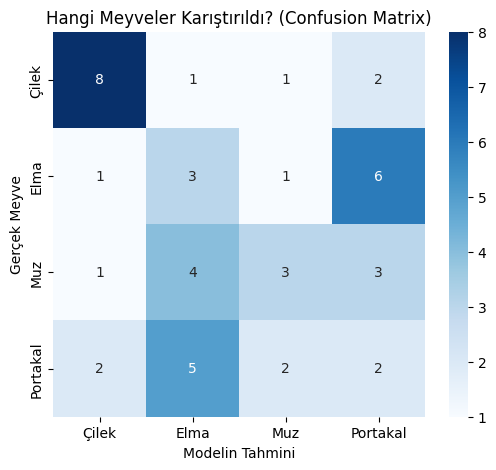

In [29]:
# Modelimize daha önce hiç görmediği test resimlerini veriyoruz ve 
# "Sence bunlar hangi meyve?" diye soruyoruz
y_pred = rf_model.predict(X_test_hog)

# Doğruluk (Accuracy) oranını hesaplıyoruz:100 resimden kaçını doğru bildi
acc = accuracy_score(y_test, y_pred)
print(f"Test Başarı Oranı: %{acc * 100:.2f}\n")

# Sadece genel başarıyı değil çileği mi daha iyi tanıyor, muzu mu karıştırıyor burada görüyoruz
print("Detaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=["Çilek", "Elma", "Muz", "Portakal"]))

# Karmaşıklık Matrisi (Confusion Matrix) hesaplama:
# Hangi meyveyi hangisiyle karıştırdığını sayısal olarak hazırlıyoruz
cm = confusion_matrix(y_test, y_pred)

# Hazırladığımız bu karmaşıklık matrisini bir tabloya döküyoruz
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Çilek", "Elma", "Muz", "Portakal"],
            yticklabels=["Çilek", "Elma", "Muz", "Portakal"])
plt.xlabel("Modelin Tahmini")
plt.ylabel("Gerçek Meyve")
plt.title("Hangi Meyveler Karıştırıldı? (Confusion Matrix)")
plt.show()

In [10]:
# CNN modelinin pikselleri daha rahat işlemesi için verileri 0-1 arasına çektik(normalizasyon yaptık)
X_train_cnn = X_train / 1.0
X_val_cnn = X_val / 1.0
X_test_cnn = X_test / 1.0

print("CNN verileri hazır:")
# Eğitim doğrulama ve test kümelerimizin kaç resimden oluştuğunu son kez kontrol ettik
print("Train:", X_train_cnn.shape)
print("Validation:", X_val_cnn.shape)
print("Test:", X_test_cnn.shape)

CNN verileri hazır:
Train: (210, 128, 128, 3)
Validation: (45, 128, 128, 3)
Test: (45, 128, 128, 3)


In [12]:
# Katmanları üst üste dizerek bir CNN (Yapay Sinir Ağı) modeli oluşturuyoruz
model = models.Sequential([
    # Giriş katmanı: Resimlerin 128x128 boyutunda ve 3 renkli (RGB) geleceğini belirttik
    layers.Input(shape=(128, 128, 3)),
    # 1.Katman:Resimdeki kenarları ve basit şekilleri yakalamak için filtre uyguladık
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # Resmin boyutunu küçülterek sadece en önemli bilgileri tuttuk
    layers.MaxPooling2D((2, 2)),

    #2.Katman:Daha karmaşık şekilleri meyvenin yuvarlaklığı gibi anlamak için filtreyi artırdık
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #3.Katman:Artık çok daha detaylı özellikleri öğreniyoruz
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #Resimdeki tüm kare veriyi tek bir uzun liste (vektör) haline getirdik
    layers.Flatten(),
    #Bilgileri birleştirip meyvenin ne olduğunu anlamaya çalışan ana beyin katmanı
    layers.Dense(128, activation='relu'),
    # Model ezber yapmasın diye bazı verileri rastgele sildik 
    layers.Dropout(0.3),
    #Sonuç katmanı:4 farklı meyveden (çilek, elma, muz, portakal) hangisi olduğunu söyler
    layers.Dense(4, activation='softmax')  
])

#Modelin çalışma kurallarını belirliyoruz
model.compile(
    optimizer='adam', # Modeli en hızlı şekilde eğiten akıllı yöntemi seçtik
    loss='sparse_categorical_crossentropy', # Hata payımızı nasıl hesaplayacağımızı belirledik
    metrics=['accuracy'] # Başarımızı doğruluk yüzdesimüzerinden takip edeceğiz
)

# Kurduğumuz bu yapının özetini (tablosunu) ekrana yazdırdık
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Modelin eğitimini (öğrenme sürecini) başlatıyoruz ve tüm süreci history değişkenine kaydediyoruz
history = model.fit(
    # Eğitim verilerimizi (X) ve bu verilerin hangi meyve olduğunu (y) modele verdik
    X_train_cnn, y_train,
    
    # Epoch: Tüm veri kümesinin modelin önünden kaç kez geçeceğini belirledik
    #15 tur dönerek modelin iyice öğrenmesini istedik
    epochs=15,
    
    # Batch Size:Verileri modele 16 şarlı paketler halinde gönderdik
    batch_size=16,
    
    # Validation Data: Model her tur sonunda "nasıl gidiyorum?" diye doğrulama verilerine bakarak kendi başarısını test etti
    validation_data=(X_val_cnn, y_val)
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.2619 - loss: 1.5392 - val_accuracy: 0.5556 - val_loss: 1.2907
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5286 - loss: 1.0692 - val_accuracy: 0.3556 - val_loss: 1.2063
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.6286 - loss: 0.8641 - val_accuracy: 0.8000 - val_loss: 0.6638
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7476 - loss: 0.6252 - val_accuracy: 0.7333 - val_loss: 0.5877
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8333 - loss: 0.4904 - val_accuracy: 0.8222 - val_loss: 0.6145
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9000 - loss: 0.3736 - val_accuracy: 0.8444 - val_loss: 0.4772
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9238 - loss: 0.3154 - val_accuracy: 0.8889 - val_loss: 0.4830
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9238 - loss: 0.2478 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 
              precision    recall  f1-score   support

       Çilek       0.92      1.00      0.96        12
        Elma       1.00      0.91      0.95        11
         Muz       1.00      0.73      0.84        11
    Portakal       0.79      1.00      0.88        11

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



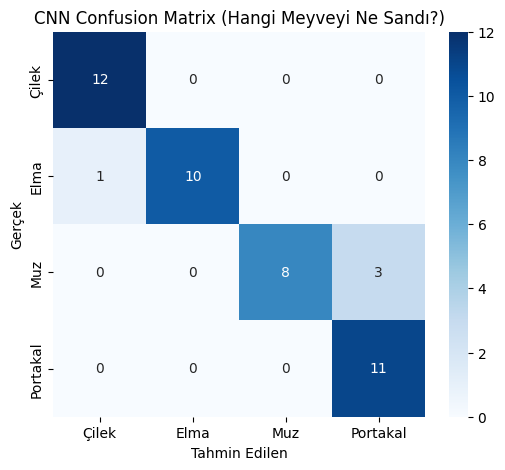

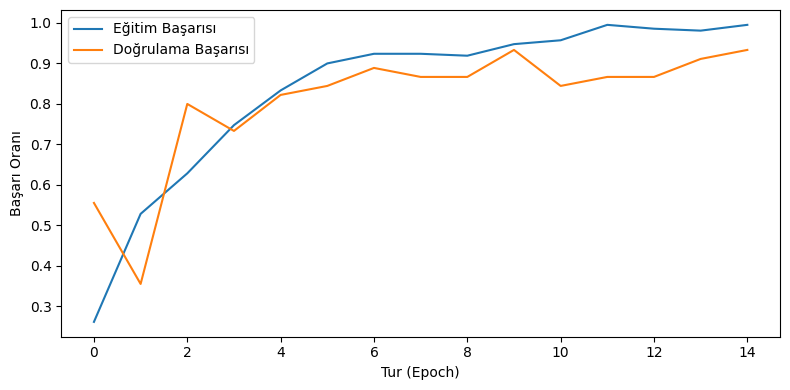

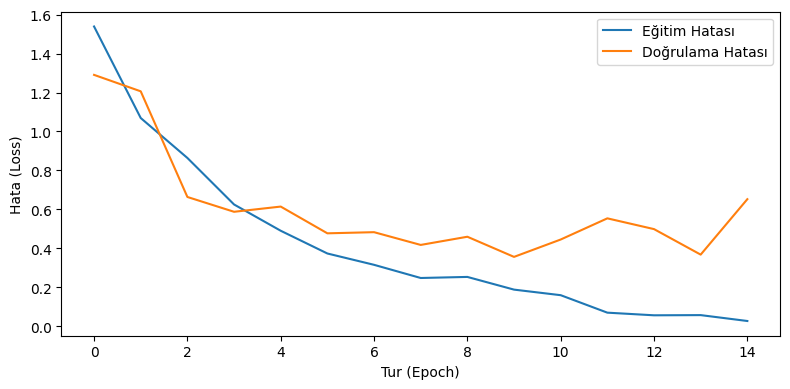

              precision    recall  f1-score   support

       Çilek       0.67      0.67      0.67        12
        Elma       0.23      0.27      0.25        11
         Muz       0.43      0.27      0.33        11
    Portakal       0.15      0.18      0.17        11

    accuracy                           0.36        45
   macro avg       0.37      0.35      0.35        45
weighted avg       0.38      0.36      0.36        45



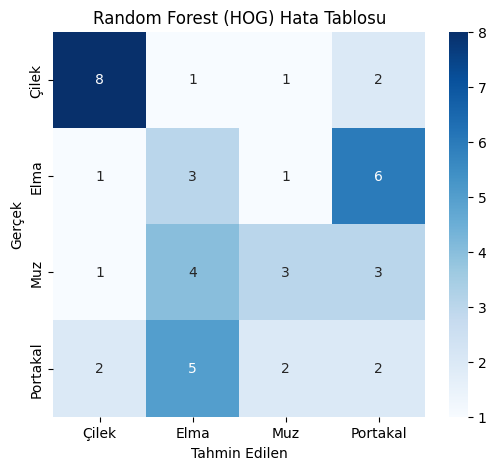

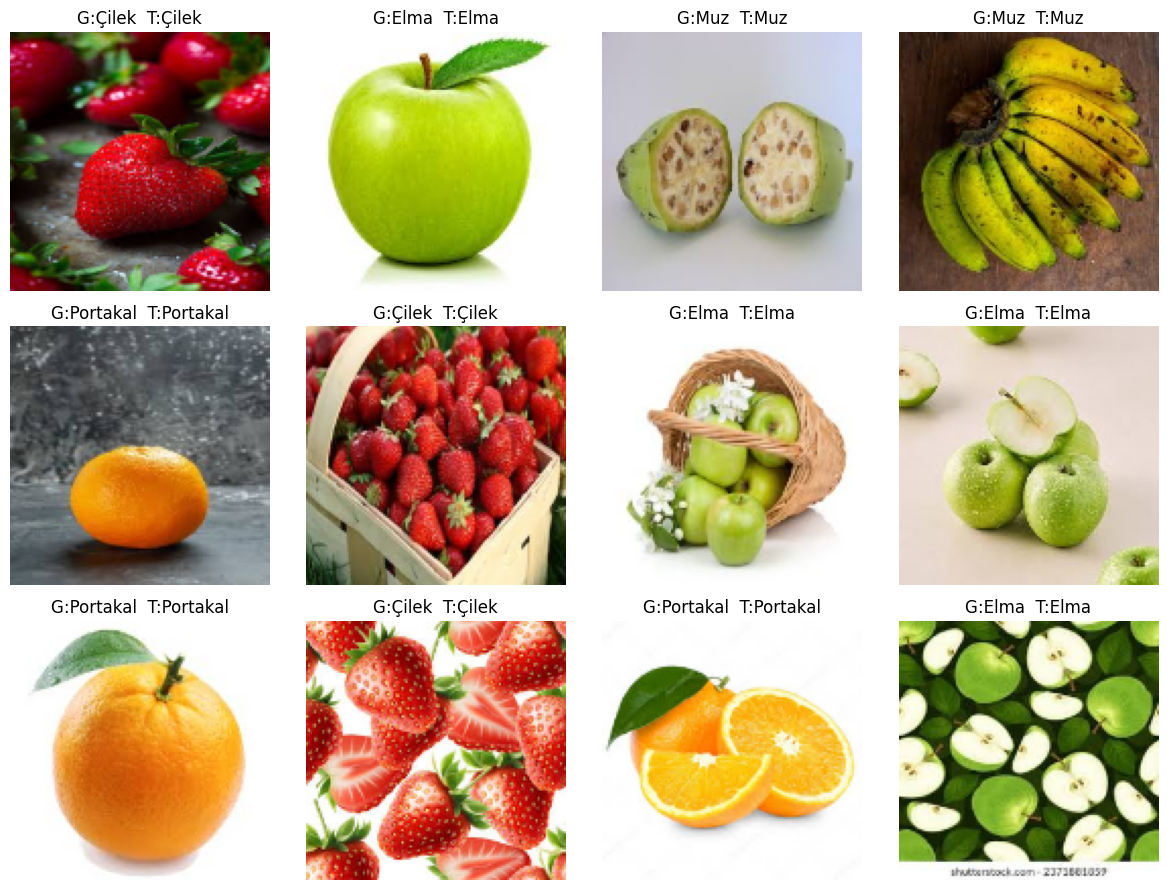

In [15]:
# CNN MODELİNİN SINAV SONUÇLARI

# Modeli hiç görmediği test verileriyle test ettik ve kaç puan aldığını hesapladık
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
# Modelin her resim için verdiği ihtimalleri aldık
y_prob = model.predict(X_test_cnn)
# En yüksek ihtimal hangi meyveyse 0,1,2,3 onu tahmin olarak seçtik
y_pred = np.argmax(y_prob, axis=1)

target_names = ["Çilek", "Elma", "Muz", "Portakal"]
# CNN'in ne kadar başarılı olduğunu gösteren detaylı raporu ekrana yazdırdık
print(classification_report(y_test, y_pred, target_names=target_names))

# CNN için hangi meyvenin hangisiyle karıştığını gösteren tabloyu çizdik
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("CNN Confusion Matrix (Hangi Meyveyi Ne Sandı?)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# EĞİTİM SÜRECİ GRAFİKLERİ 

# Modelin 15 tur boyunca başarısının nasıl arttığını gösteren grafiği çizdik
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarısı')
plt.xlabel("Tur (Epoch)")
plt.ylabel("Başarı Oranı")
plt.legend()
plt.tight_layout()
plt.show()

# Modelin hata payının zamanla nasıl düştüğünü gösteren grafiği çizdik
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Eğitim Hatası')
plt.plot(history.history['val_loss'], label='Doğrulama Hatası')
plt.xlabel("Tur (Epoch)")
plt.ylabel("Hata (Loss)")
plt.legend()
plt.tight_layout()
plt.show()

#  RANDOM FOREST (HOG) KARŞILAŞTIRMASI 

# CNN ile kıyaslamak için Random Forest modelimize de tahmin yaptırdık
y_pred_rf = rf_model.predict(X_test_hog)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

# Random Forest'ın hata tablosunu (Confusion Matrix) çizdirdik
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Random Forest (HOG) Hata Tablosu")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

#  MODELLERİ CÜZDANA KOYMA (KAYDETME)

# Eğittiğimiz modelleri sonra da kullanalım diye bilgisayara kaydettik
os.makedirs("models", exist_ok=True)
model.save("models/cnn_fruit_classifier.keras") # CNN'i kaydet
joblib.dump(rf_model, "models/rf_hog_classifier.joblib") # Random Forest'ı kaydet

# GÖRSEL TEST (MODELİN GÖZÜNDEN BAKALIM) 

# Test setinden rastgele 12 tane resim seçip modelin tahminlerini resimlerin üstüne yazdık
# T: Gerçek meyve (True), P: Modelin tahmini (Predicted)
idxs = np.random.choice(len(X_test_cnn), 12, replace=False)
plt.figure(figsize=(12, 9))
for i, idx in enumerate(idxs):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test_cnn[idx])
    plt.axis("off")
    plt.title(f"G:{target_names[y_test[idx]]}  T:{target_names[y_pred[idx]]}")
plt.tight_layout()
plt.show()

In [16]:
# VERİ ÇOĞALTMA (DATA AUGMENTATION)
# Modelin aynı resmi farklı açılardan görüp daha iyi öğrenmesi için yapay çeşitlilik oluşturduk
data_augmentation = tf.keras.Sequential([
    # Resimleri rastgele yatayda çevirdik
    layers.RandomFlip("horizontal"),
    # Resimleri hafifçe %10 döndürdük
    layers.RandomRotation(0.10),
    # Resimlere hafifçe %10 yakınlaştırma yaptık
    layers.RandomZoom(0.10),
])

# YENİ MODEL (ÇOĞALTMA KATMANI DAHİL)
# Az önce kurduğumuz çoğaltma katmanını modelin en başına bir filtre gibi ekledik.
model_aug = models.Sequential([
    # Her eğitim turunda resimler buraya girip değişerek modele gidecek
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

# Kuralları belirledik (Diğer modelle aynı kuralları koyduk ki kıyaslama adil olsun)
model_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# İYİLEŞTİRİLMİŞ EĞİTİM 
# Bu sefer modeli 20 tur (epoch) eğittik
history_aug = model_aug.fit(
    X_train_cnn, y_train,
    epochs=20, # Daha iyi sonuç için tur sayısını artırdık
    batch_size=16,
    validation_data=(X_val_cnn, y_val)
)

Epoch 1/20


C:\Users\SERPİL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.3571 - loss: 1.3422 - val_accuracy: 0.6667 - val_loss: 0.9448
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6667 - loss: 0.8686 - val_accuracy: 0.6222 - val_loss: 0.7413
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.6810 - loss: 0.7959 - val_accuracy: 0.6889 - val_loss: 0.9132
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7810 - loss: 0.5690 - val_accuracy: 0.8000 - val_loss: 0.4784
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.8000 - loss: 0.5273 - val_accuracy: 0.8444 - val_loss: 0.5464
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8810 - loss: 0.4010 - val_accuracy: 0.8667 - val_loss: 0.5321
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8857 - loss: 0.4202 - val_accuracy: 0.7111 - val_loss: 0.6299
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.8143 - loss: 0.4880 - val_accuracy: 0.8000 - val_

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
              precision    recall  f1-score   support

       Çilek       0.92      0.92      0.92        12
        Elma       0.83      0.91      0.87        11
         Muz       0.86      0.55      0.67        11
    Portakal       0.79      1.00      0.88        11

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.83        45
weighted avg       0.85      0.84      0.84        45



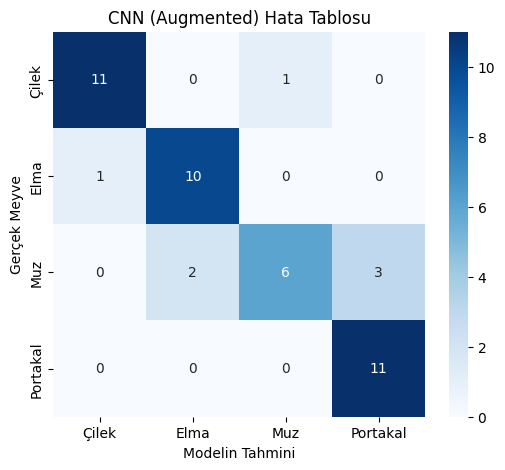

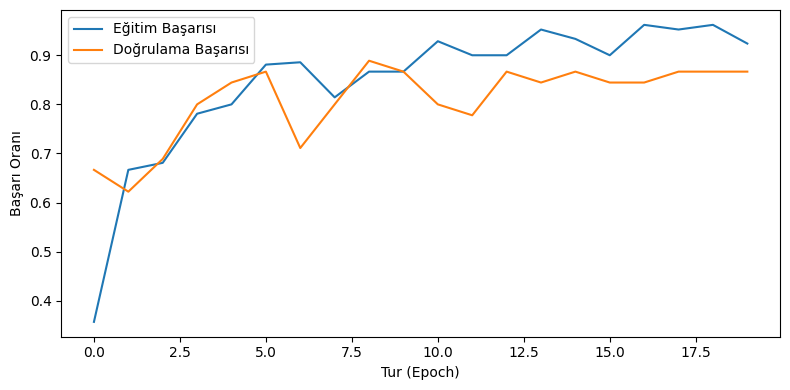

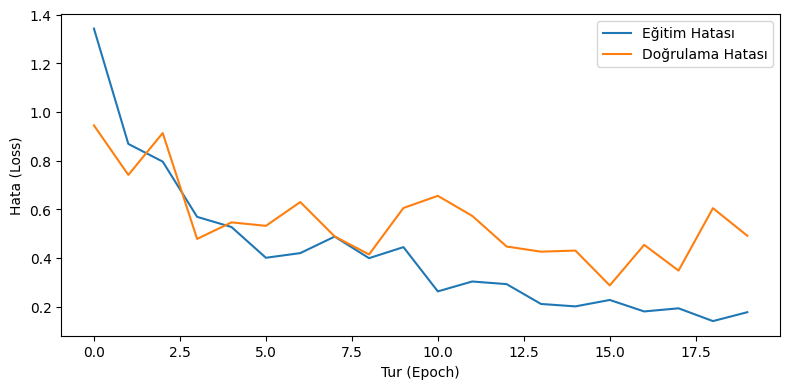

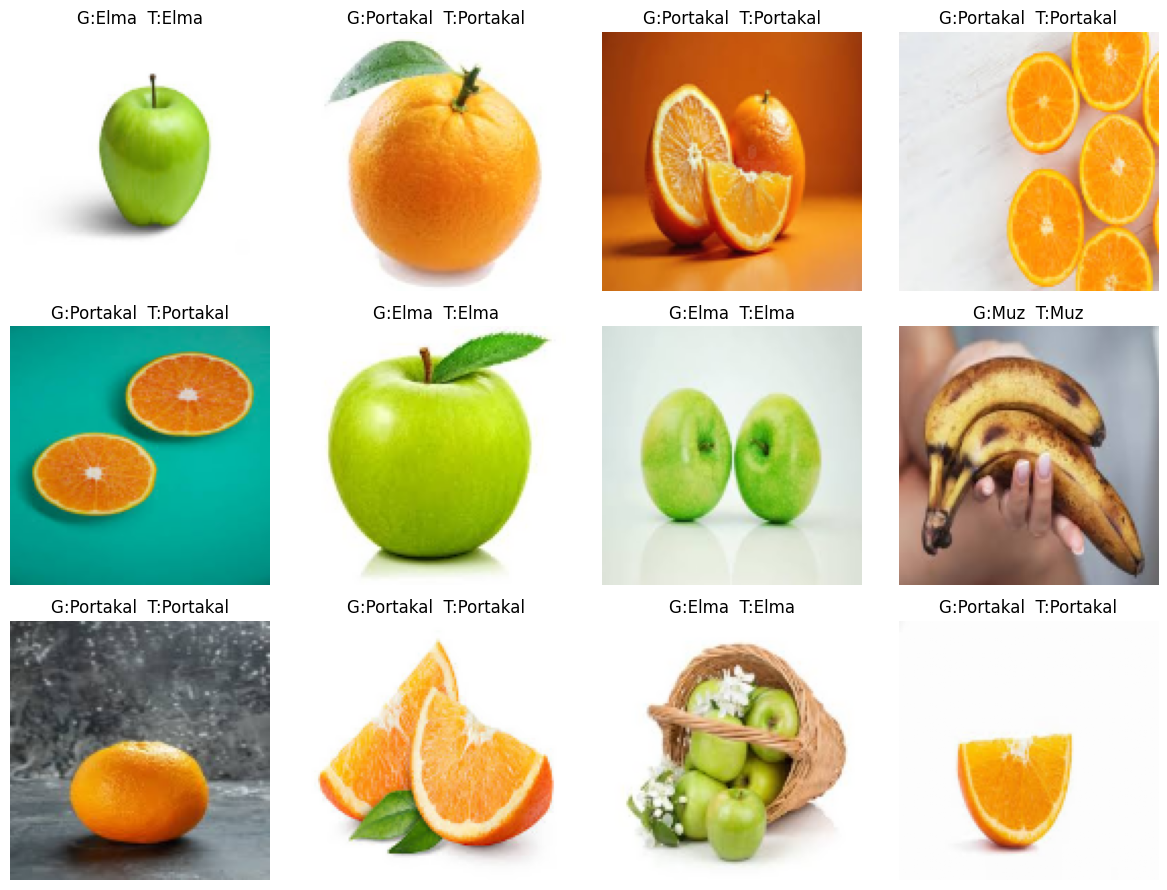

In [20]:
#İYİLEŞTİRİLMİŞ (AUGMENTED) MODELİN TESTİ 

# Veri çoğaltma uyguladığımız modelin hiç görmediği resimlerdeki başarısını ölçtük
test_loss_aug, test_acc_aug = model_aug.evaluate(X_test_cnn, y_test, verbose=0)
# Modelin tahmin ihtimallerini aldık
y_prob_aug = model_aug.predict(X_test_cnn)
# En yüksek ihtimalli meyveyi tahmin olarak seçtik
y_pred_aug = np.argmax(y_prob_aug, axis=1)

target_names = ["Çilek", "Elma", "Muz", "Portakal"]
# Modelin başarısını gösteren detaylı raporu (Precision, Recall, F1-Score) yazdırdık
print(classification_report(y_test, y_pred_aug, target_names=target_names))

# GÖRSEL SONUÇLAR VE GRAFİKLER 

# İyileştirilmiş modelin hangi meyveyi hangisiyle karıştırdığını gösteren tabloyu çizdik
cm_aug = confusion_matrix(y_test, y_pred_aug)
plt.figure(figsize=(6,5))
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("CNN (Augmented) Hata Tablosu")
plt.xlabel("Modelin Tahmini")
plt.ylabel("Gerçek Meyve")
plt.show()

# 20 tur (epoch) boyunca başarının nasıl değiştiğini grafik haline getirdik
plt.figure(figsize=(8,4))
plt.plot(history_aug.history['accuracy'], label='Eğitim Başarısı')
plt.plot(history_aug.history['val_accuracy'], label='Doğrulama Başarısı')
plt.xlabel("Tur (Epoch)")
plt.ylabel("Başarı Oranı")
plt.legend()
plt.tight_layout()
plt.show()

# Modelin hata payının eğitim süresince nasıl azaldığını grafik olarak çizdik
plt.figure(figsize=(8,4))
plt.plot(history_aug.history['loss'], label='Eğitim Hatası')
plt.plot(history_aug.history['val_loss'], label='Doğrulama Hatası')
plt.xlabel("Tur (Epoch)")
plt.ylabel("Hata (Loss)")
plt.legend()
plt.tight_layout()
plt.show()

# Test setinden rastgele 12 resim seçip modelin bunları bilip bilmediğini resimli olarak gösterdik
# G: Gerçek meyve, T: Modelin yaptığı tahmin
idxs = np.random.choice(len(X_test_cnn), 12, replace=False)
plt.figure(figsize=(12, 9))
for i, idx in enumerate(idxs):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test_cnn[idx])
    plt.axis("off")
    plt.title(f"G:{target_names[y_test[idx]]}  T:{target_names[y_pred_aug[idx]]}")
plt.tight_layout()
plt.show()


=== MODEL KARŞILAŞTIRMA TABLOSU ===
Random Forest (HOG) Başarı Oranı     : %35.56
Sade CNN Başarı Oranı               : %91.11
Geliştirilmiş CNN Başarı Oranı      : %84.44


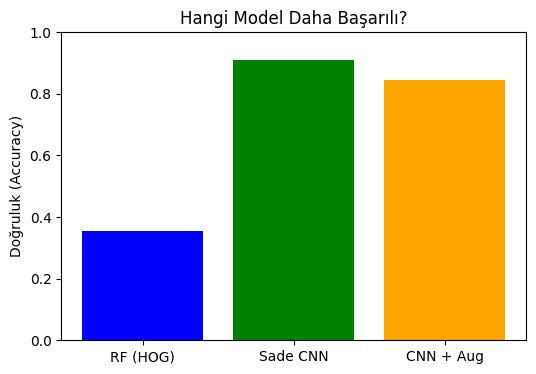

In [21]:
# MODELLERİ KAYDETME
os.makedirs("models", exist_ok=True)

# İlk eğittiğimiz sade CNN modelini kaydettik
model.save("models/cnn_model.keras")

# Veri çoğaltma yaparak güçlendirdiğimiz ikinci CNN modelini kaydettik
model_aug.save("models/cnn_augmented_model.keras")

# Random Forest (HOG tabanlı) modelimizi de ileride kullanmak üzere sakladık
joblib.dump(rf_model, "models/rf_hog_model.joblib")


# PERFORMANS KARŞILAŞTIRMA 

# Random Forest modelinin test sınavından aldığı notu başarı oranını hesapladık
rf_pred = rf_model.predict(X_test_hog)
rf_acc = accuracy_score(y_test, rf_pred)

# Sade CNN modelinin test verileri üzerindeki doğruluğunu ölçtük
test_loss, cnn_acc = model.evaluate(X_test_cnn, y_test, verbose=0)

# Veri çoğaltma uyguladığımız (Augmented) CNN modelinin son puanını aldık
test_loss_aug, cnn_aug_acc = model_aug.evaluate(X_test_cnn, y_test, verbose=0)

# Sonuçları ekranda güzelce bir tablo halinde bastırıp kıyasladık
print("\n=== MODEL KARŞILAŞTIRMA TABLOSU ===")
print(f"Random Forest (HOG) Başarı Oranı     : %{rf_acc * 100:.2f}")
print(f"Sade CNN Başarı Oranı               : %{cnn_acc * 100:.2f}")
print(f"Geliştirilmiş CNN Başarı Oranı      : %{cnn_aug_acc * 100:.2f}")

# SONUÇLARI GRAFİĞE DÖKME

# Modellerin isimlerini ve aldıkları puanları hazırladık
model_names = ["RF (HOG)", "Sade CNN", "CNN + Aug"]
accuracies = [rf_acc, cnn_acc, cnn_aug_acc]

# Raporumuzun en önemli görseli olan Sütun Grafiğini çizdik
# Hangi modelin çıtasının daha yüksek olduğunu burada netçe gördük
plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0, 1) # Başarı oranı 0 ile 1 (yani %100) arasında olsun
plt.ylabel("Doğruluk (Accuracy)")
plt.title("Hangi Model Daha Başarılı?")
plt.show()

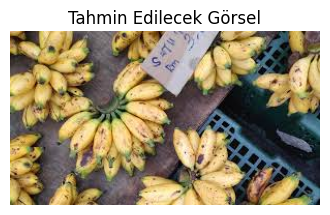

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

=== TAHMİN SONUÇLARI ===
Sade CNN             → Muz
Geliştirilmiş CNN    → Muz
Random Forest (HOG)  → Muz


In [23]:
#TEK GÖRSELİ TÜM MODELLERLE TEST ETME 

def predict_image(path):
    # Bilgisayardaki fotoğrafı okuduk
    img = io.imread(path)
    
    # Şeffaflık (4. kanal) varsa sildik sadece RGB renklerini tuttuk
    if img.ndim == 3 and img.shape[-1] == 4:
        img = img[:, :, :3]
        
    # Siyah beyaz fotoğraf gelirse renkliymiş gibi 3 kanala çevirdik
    if img.ndim == 2:
        img = np.stack((img,)*3, axis=-1)

    # Seçtiğimiz fotoğrafı ekrana bastırıp tahmin edilecek görsel budur dedik
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Tahmin Edilecek Görsel")
    plt.show()

    # Modellerimizin eğitildiği standart boyuta (128x128) getirdik
    img_resized = transform.resize(img, (128, 128), anti_aliasing=True)

    # CNN modeli tek bir resim de olsa liste şeklinde veri beklediği için boyutunu ayarladık
    img_cnn = np.expand_dims(img_resized, axis=0)

    # 1. MODEL: Sade CNN Tahmini 
    # İlk eğittiğimiz modele resmi sorduk en yüksek ihtimalli olanı seçtik
    pred_cnn = model.predict(img_cnn)
    pred_cnn_label = np.argmax(pred_cnn)

    # 2. MODEL: Geliştirilmiş CNN Tahmini
    # Veri çoğaltma uyguladığımız modele resmi sorduk
    pred_cnn_aug = model_aug.predict(img_cnn)
    pred_cnn_aug_label = np.argmax(pred_cnn_aug)

    # 3. MODEL: Random Forest (HOG) Tahmini 
    # Görüntüyü griye çevirip HOG özelliklerini kenarlarını çıkardık
    gray = np.dot(img_resized[..., :3], [0.299, 0.587, 0.114])
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm="L2-Hys")
    # Sayı dizisini RF modelinin anlayacağı tek satır haline getirdik
    hog_feat = hog_feat.reshape(1, -1)
    # RF modeline sorup meyvenin adını aldık
    pred_rf_label = rf_model.predict(hog_feat)[0]

    # Tüm sonuçları alt alta yazdırıp karşılaştırdık
    print("\n=== TAHMİN SONUÇLARI ===")
    print(f"Sade CNN             → {target_names[pred_cnn_label]}")
    print(f"Geliştirilmiş CNN    → {target_names[pred_cnn_aug_label]}")
    print(f"Random Forest (HOG)  → {target_names[pred_rf_label]}")
    

# FONKSİYONU ÇALIŞTIRMA
# Klasörümüzden örnek bir fotoğraf verip modelleri denedik.
predict_image("makinedataset/muz_dataset/23.jpeg")

In [24]:
# FİNAL RAPORU İÇİN TÜM SONUÇLARI TOPLAMA

# Random Forest modelimizin son sınav notunu (Accuracy) hesapladık
rf_pred = rf_model.predict(X_test_hog)
rf_acc = accuracy_score(y_test, rf_pred)

# Standart CNN modelimizi test ettik ve genel başarı puanını aldık
_, cnn_acc = model.evaluate(X_test_cnn, y_test, verbose=0)

# Veri çoğaltma ile iyileştirdiğimiz CNN modelinin son puanını aldık
_, cnn_aug_acc = model_aug.evaluate(X_test_cnn, y_test, verbose=0)

# Meyvelerimizin isimlerini bir listeye koyduk raporlarda düzgün görünsün diye
target_names = ["Çilek", "Elma", "Muz", "Portakal"]

# Her üç model için de "Hangi meyveyi ne kadar bildi?" raporlarını (Precision, Recall) hazırladık
report_rf = classification_report(y_test, rf_pred, target_names=target_names)
report_cnn = classification_report(y_test, model.predict(X_test_cnn).argmax(axis=1), target_names=target_names)
report_aug = classification_report(y_test, model_aug.predict(X_test_cnn).argmax(axis=1), target_names=target_names)

# SONUÇLARI EKRANA YAZDIRMA

# Tüm modellerin genel başarı yüzdelerini yan yana getirip hangisi daha iyi gördük
print("=== MODEL PERFORMANS KARŞILAŞTIRMASI ===\n")
print(f"Random Forest (HOG) Başarı Oranı     : %{rf_acc*100:.2f}")
print(f"Sade CNN Başarı Oranı               : %{cnn_acc*100:.2f}")
print(f"Geliştirilmiş CNN Başarı Oranı      : %{cnn_aug_acc*100:.2f}")

# Raporunun "Sonuç ve Tartışma" kısmına eklemek için detaylı sınıf bazlı listeleri bastırdık
print("\n=== Random Forest Sınıf Bazlı Rapor (Hangi meyvede daha iyi?) ===")
print(report_rf)

print("=== Sade CNN Sınıf Bazlı Rapor (Hangi meyvede daha iyi?) ===")
print(cnn_acc)

print("=== Geliştirilmiş CNN Sınıf Bazlı Rapor (Hangi meyvede daha iyi?) ===")
print(report_aug)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
=== MODEL PERFORMANS KARŞILAŞTIRMASI ===

Random Forest (HOG) Başarı Oranı     : %35.56
Sade CNN Başarı Oranı               : %91.11
Geliştirilmiş CNN Başarı Oranı      : %84.44

=== Random Forest Sınıf Bazlı Rapor (Hangi meyvede daha iyi?) ===
              precision    recall  f1-score   support

       Çilek       0.67      0.67      0.67        12
        Elma       0.23      0.27      0.25        11
         Muz       0.43      0.27      0.33        11
    Portakal       0.15      0.18      0.17        11

    accuracy                           0.36        45
   macro avg       0.37      0.35      0.35        45
weighted avg       0.38      0.36      0.36        45

=== Sade CNN Sınıf Bazlı Rapor (Hangi meyvede daha iyi?) ===
0.9111111164093018
=== Geliştirilmiş CNN Sınıf Bazlı Rapor (Hangi meyvede daha iyi?) ===
              precision    recall  f1-score   support

       Çilek       0.92      0.92    

Ön İşleme ve Veri Hazırlığı

Görseller Google Görseller üzerinden manuel olarak toplanmış, her sınıf için yaklaşık 75 görüntü elde edilmiştir. Tüm görüntüler 128×128 piksel boyutuna ölçeklendirilmiş, RGBA veya gri formatındaki görüntüler uygun şekilde dönüştürülmüştür. Veri kümesi %70 eğitim, %15 doğrulama ve %15 test olarak ayrılmıştır. Elma sınıfı içerisinde tutarlılık sağlamak amacıyla yalnızca yeşil elma görselleri kullanılmıştır.

1. Yöntem: HOG + Random Forest 

Klasik makine öğrenmesi yaklaşımı olarak HOG özellik çıkarımı ve Random Forest sınıflandırıcısı birlikte kullanılmıştır. HOG yalnızca kenar ve doku bilgisi sağladığından renk ayrımının belirgin olduğu bu problemde sınıflar arası ayrımı etkin şekilde gerçekleştirememiştir. Modelin test doğruluğu %35.56 olarak elde edilmiştir ve bu yöntem sınıflar arası karışıklığa karşı duyarlıdır.

2. Yöntem: Convolutional Neural Network (CNN)

Derin öğrenme yaklaşımı olarak üç konvolüsyon katmanı içeren bir CNN modeli eğitilmiştir. Bu model, görüntülerin renk, doku ve şekil özelliklerini birlikte öğrenebilmiş ve Random Forest yöntemine kıyasla önemli ölçüde daha yüksek performans göstermiştir. CNN modelinin test doğruluğu %84.44 olarak elde edilmiştir.

3. Yöntem: Veri Artırma (Data Augmentation) + CNN

Modelin genellenebilirliğini artırmak amacıyla rastgele döndürme, çevirme ve yakınlaştırma işlemlerini içeren veri artırma uygulanmıştır. Veri artırma sayesinde modelin aşırı öğrenimi azalmış, farklı koşullarda daha kararlı tahminler üretmesi sağlanmıştır. Bu model test kümesinde %91.11 doğruluk ile en yüksek başarıyı göstermiştir.

4. Karşılaştırmalı Performans Değerlendirmesi
Model	Test Doğruluğu
HOG + Random Forest	%35.56
CNN	%84.44
CNN (Veri Artırma ile)	%91.11

Sonuçlar, derin öğrenme tabanlı yöntemlerin klasik makine öğrenmesi yöntemlerine göre belirgin şekilde üstün performans gösterdiğini ortaya koymaktadır. Özellikle veri artırma uygulanmış CNN modeli tüm sınıflarda yüksek doğruluk ve tutarlı sonuçlar üretmiştir.

5. Sonuç

Bu çalışma, meyve görüntülerinin sınıflandırılmasında derin öğrenme yöntemlerinin etkinliğini göstermektedir. Klasik HOG + Random Forest yaklaşımı düşük performans sergilerken, CNN modelleri yüksek doğruluk oranlarına ulaşmıştır. Veri artırma uygulaması model performansını daha da artırarak en başarılı sonuçları vermiştir.

Bu nedenle projenin final modeli olarak “Veri Artırmalı CNN” yöntemi seçilmiştir.

